In [1]:
import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras import metrics,optimizers
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Setting up images path
# Linux path
PATH = "/home/changsmarter/Desktop/myAI_Project/7classes_data/"
SELECTED_CLASS = "10000_NoF_Class.csv"
SELECTED_LABEL = "Is No_Finding"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('temp/*/*/*.jpg')))
image_csv = pd.read_csv(PATH+SELECTED_CLASS)
CLASS_NAME = image_csv[SELECTED_LABEL].unique()
# Check number of TRUE file and all file count        
print(image_num)
print(CLASS_NAME)

10000
['No' 'Yes']


In [3]:
##loading image from given path
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = PATH + "temp/train/"
VALID_PATH = PATH + "temp/valid/"
TEST_PATH = PATH + "temp/test/"
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                  classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my valid_set . 
data_gen_valid = my_generator.flow_from_directory(directory=VALID_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
#This will be my test_set . 
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 classes = list(CLASS_NAME),
                                                  class_mode = 'binary')
x_train,y_train = next(data_gen_train)
x_valid,y_valid = next(data_gen_valid)
x_test,y_test = next(data_gen_test)

Found 8001 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [98]:
##Using ResNet50
import tensorflow_hub as hub
myResNet = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4",trainable=False)
 
#out = myResNet.output
#out = layers.GlobalAveragePooling2D()(out)
#out = layers.Dropout(0.5)(out)
#out = layers.Dense(1,activation='sigmoid')(out)

myModel = tf.keras.Sequential([
    myResNet,
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(1,activation='sigmoid'),
])
myModel.build([None,224,224,3])

In [99]:
myModel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   multiple                  25615849  
_________________________________________________________________
dropout_18 (Dropout)         multiple                  0         
_________________________________________________________________
dense_32 (Dense)             multiple                  128256    
_________________________________________________________________
dense_33 (Dense)             multiple                  129       
Total params: 25,744,234
Trainable params: 128,385
Non-trainable params: 25,615,849
_________________________________________________________________


In [100]:
## Setting up callback function for detecting training status
myEarly = EarlyStopping(monitor='val_loss',patience=2,verbose=1)
myCheckpoint = ModelCheckpoint('myResNet50.hdf5',monitor='val_loss')
#Callback function when my model hit my max ACC
class mystopclass(Callback):
    def on_epoch_end(self,epoch,log={}):
        if(log.get('accuracy') > 0.999 or log.get('loss') < 0.001):
            print("\n\nReached my Destination. Stoppped Training!!\n\n")
            self.model.stop_training = True
myStop = mystopclass()

In [101]:
myModel.compile(loss='binary_crossentropy',
                    optimizer=optimizers.SGD(lr=1e-4)
                ,metrics=['accuracy',metrics.AUC(),metrics.Precision(),
               metrics.Recall()])

In [102]:
TRAIN_IMG = 8001
TEST_IMG = 1000
VALID_IMG = 1000

In [103]:
#Training myModel
STEP_PER_EPOCH = np.ceil(TRAIN_IMG/BATCH_SIZE)
mySession = myModel.fit_generator(data_gen_train,
                               validation_data=data_gen_valid,
                               epochs = 5,
                               steps_per_epoch=STEP_PER_EPOCH,
                               validation_steps = 30,
                               verbose = 1,
                               callbacks=[myEarly,myCheckpoint,myStop])

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 251.0 steps, validate for 30 steps
Epoch 1/5
251/251 [==============================] - 30s 121ms/step - loss: 0.7981 - accuracy: 0.6893 - auc_11: 0.4650 - precision_11: 0.1390 - recall_11: 0.1904 - val_loss: 0.5813 - val_accuracy: 0.7948 - val_auc_11: 0.4052 - val_precision_11: 0.1034 - val_recall_11: 0.0397
Epoch 2/5
251/251 [==============================] - 27s 106ms/step - loss: 0.6644 - accuracy: 0.7710 - auc_11: 0.4868 - precision_11: 0.1372 - recall_11: 0.0880 - val_loss: 0.5273 - val_accuracy: 0.8177 - val_auc_11: 0.4329 - val_precision_11: 0.1000 - val_recall_11: 0.0199
Epoch 3/5
251/251 [==============================] - 26s 105ms/step - loss: 0.6517 - accuracy: 0.7757 - auc_11: 0.4855 - precision_11: 0.1520 - recall_11: 0.0952 - val_loss: 0.4957 - val_accuracy: 0.8271 - val_auc_11: 0.4725 - val_precision_11: 0.1429 - val_recall_11: 0.0199
Epoch 4/5
251/251 [==============================] - 26s 104ms/step - loss: 0.5998 - accuracy: 0.7888 - auc_11: 0.5220 - precis

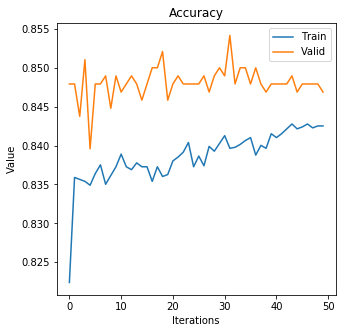

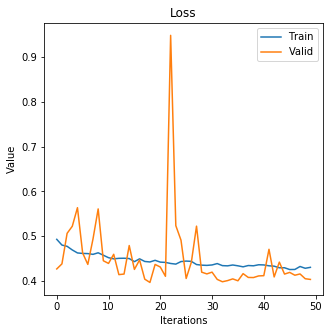

In [10]:
plt.figure(figsize=(5,5))
plt.plot(mySession.history['accuracy'])
plt.plot(mySession.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig("Phase1_ResNet50_Accuracy.png")
plt.show()
plt.figure(figsize=(5,5))
plt.plot(mySession.history['loss'])
plt.plot(mySession.history['val_loss'])
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('Iterations')
plt.legend(['Train','Valid'])
plt.savefig("Phase1_ResNet50_Loss.png")
plt.show()

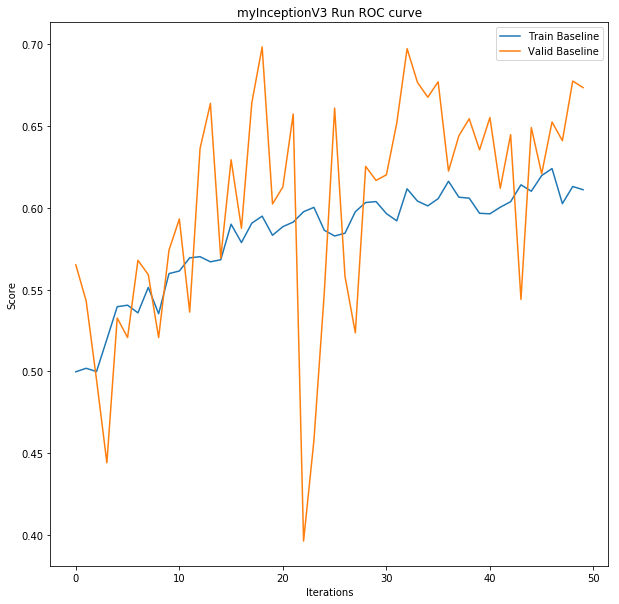

In [11]:
plt.figure(figsize=(10,10))
plt.plot(mySession.history['auc'])
plt.plot(mySession.history['val_auc'])
plt.title("myResNet50 Run ROC curve")
plt.legend({'Train Baseline','Valid Baseline'})
plt.ylabel('Score')
plt.xlabel('Iterations')
plt.savefig("myResNet50_Run_ROC.png")
plt.show()